<a href="https://colab.research.google.com/github/CuadraAlconero/IDAL_IA3_CuadraAlconero/blob/main/Traducci%C3%B3n_m%C3%A1quina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

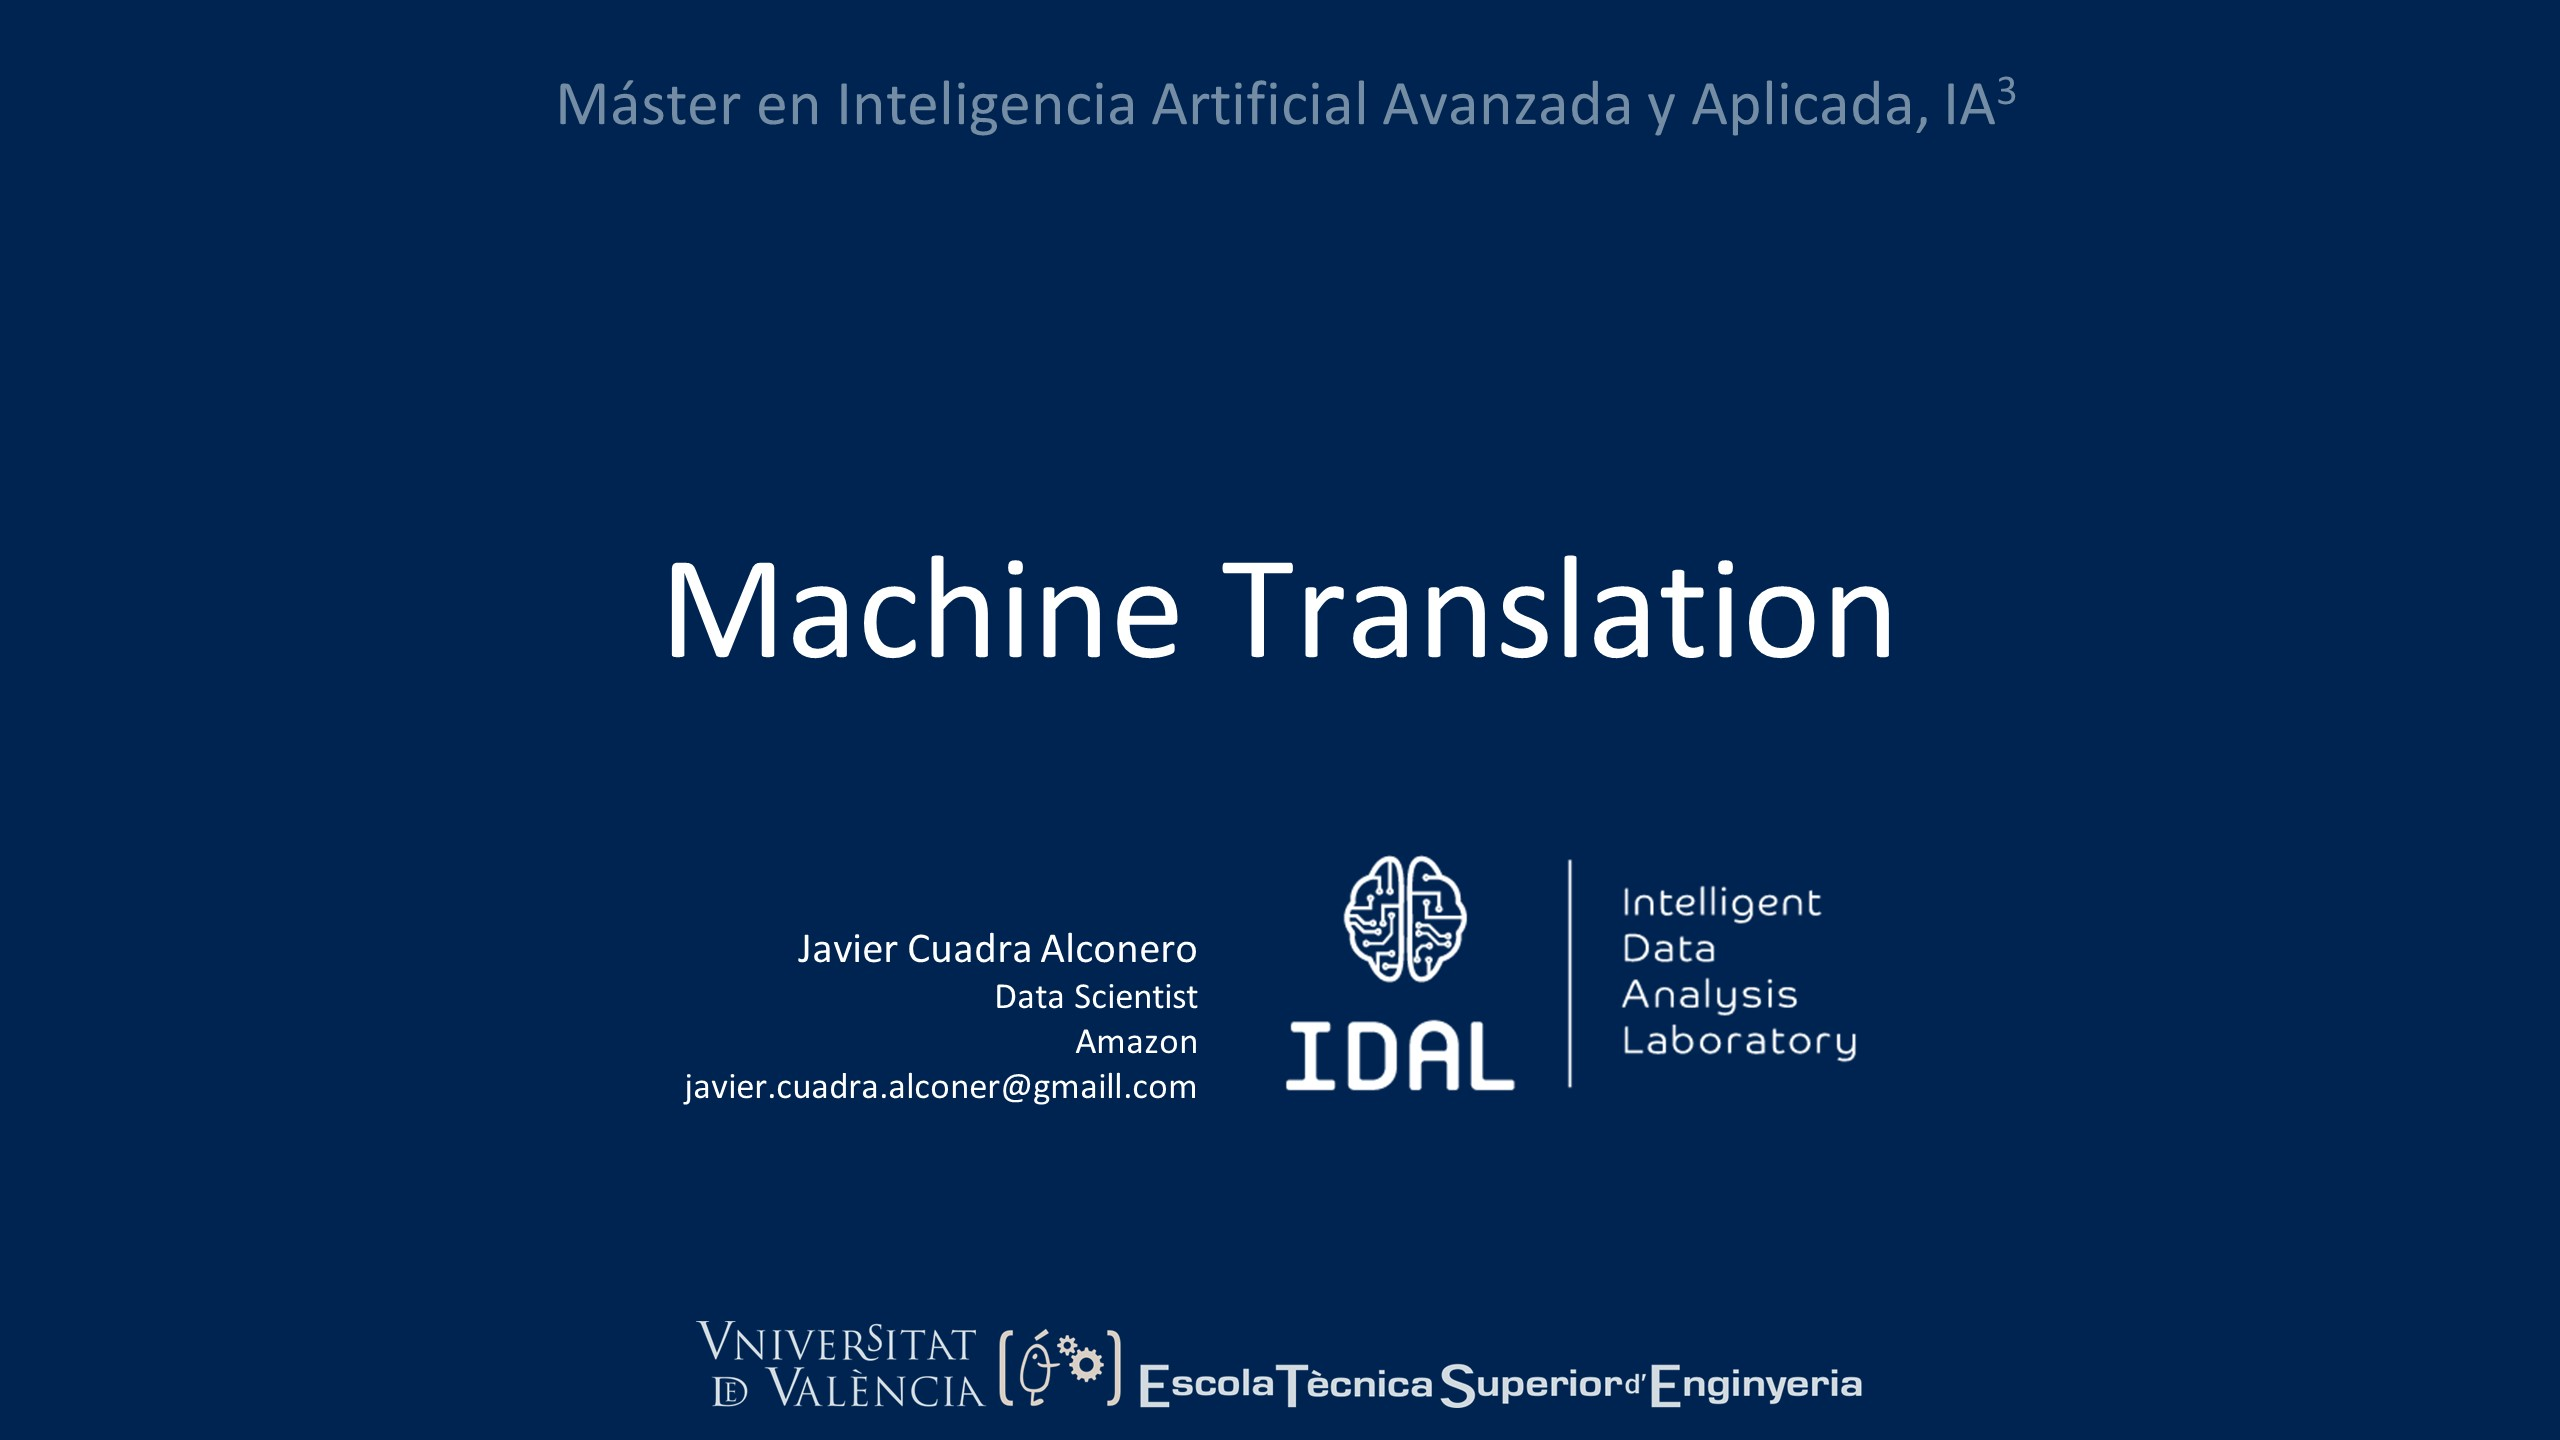

El problema de la traducción automática queda definido por la necesidad de codificar una secuencia en un idioma (encoder) y decodificarla en otro idioma (decoder). El principal reto en estas arquitecturas es ser capaz de codificar de manera apropiada la información de la frase original, teniendo en cuenta todos los matices que el idioma puede aportar y trasladarlo a otra lengua, dotando a la frase de la coherencia y estructuras correctas.

No vamos a estudiar el problema en profundidad, pero si una de sus arquitecturas más famosas, sus problemas y su evolución.

# Encoder - Decoder LSTM/GRU

La arquitectura encoder/decoder se compone de dos redes diferentes. El encoder es la parte de la arquitectura encargada de codificar la secuencia original, el texto que deseamos traducir. El decoder, es otro modelo secuencial, cuya función principal será decodificar el texto/secuencia original en otro idioma.

La arquitectura final toma esta forma:

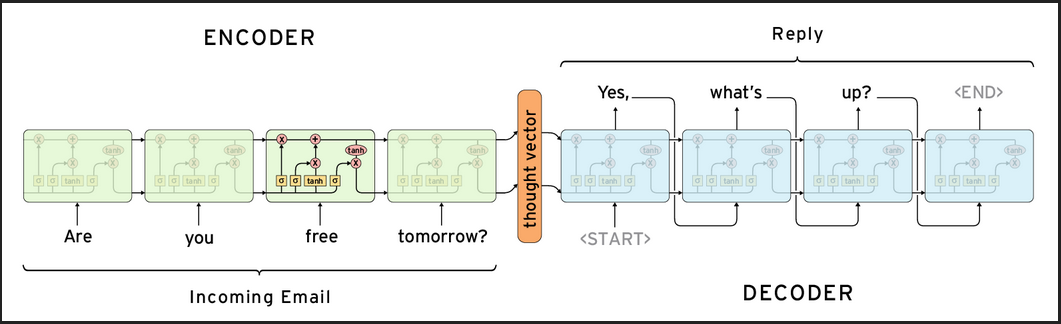

Imagen extraída de: https://www.codespeedy.com/language-translator-rnn-bidirectional-lstms-and-attention-in-python/

Existen diversas variaciones y técnicas de esta arquitectura, pero por norma general se siguen los siguientes pasos de diseño:

- Construyes la capa encoder. Este modelo secuencial de LSTM/gru no necesita ser una única capa. Podéis "stackear" varias capas LSTM/GRU para generar un modelo profundo. El output de la última celda (h y c) sirven como entrada para el decoder. Este output contiene la información de la secuencia que el encoder ha sido capaz de capturar.

- El segundo modelo funciona de forma diferente durante el entrenamiento y en predicción/testeo. 

- Durante el entrenamiento aplicamos la técnica teacher-forcing (al menos en traducción máquina), durante la predicción utilizaremos el estado generado por la celda anterior.

- Las entradas y las salidas de los modelos pueden ser una capa de embedding o una vectorización sencilla como el one-hot encoding.

# Teacher Forcing

La técnica de teacher forcing es relativamente sencilla a la par que efectiva cuando se trabaja con modelos secuenciales.

Teacher Forcing se basa en separar la inferencia del entrenamiento del modelo. Para ello en vez de introducir la salida de la celda anterior como nueva entrada al modelo introducimos el valor correcto directamente del training set.

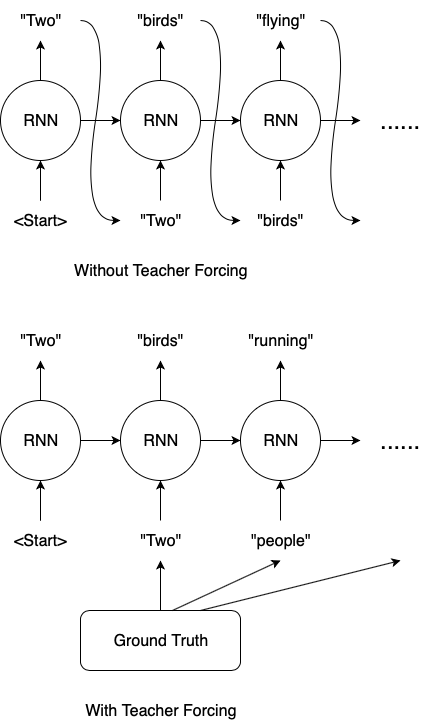

Imagen extraída de: https://towardsdatascience.com/what-is-teacher-forcing-3da6217fed1c

# Ejemplo

Construyamos una arquitectura encoder-decoder para traducción máquina

Descargad el dataset de aquí https://drive.google.com/file/d/12UzXEhRVgIXda8t78D9PgHyJmttvWWVY/view?usp=sharing

In [1]:
import tensorflow.keras as keras
from gensim.utils import tokenize
from gensim.corpora.dictionary import Dictionary
#from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
#Importamos el dataset
import pandas as pd
dataset = pd.read_csv("/content/Sentence pairs in Español-Inglés - 2021-05-14 (2).tsv", sep="\t", header=None)
dataset.dropna(inplace=True)
dataset = dataset.iloc[0:100]
dataset.head(3)
dataset.shape

(100, 4)

In [4]:
# Añadimos los caracteres start, end 
list_sentences = list()
for text in dataset[3]:
  new_text = "STARTSEQ "+text+" ENDSEQ"
  list_sentences.append(new_text)
dataset[3] = list_sentences
dataset.head(3)

,0,1,2,3
0,2481,¡Intentemos algo!,1276.0,STARTSEQ Let's try something. ENDSEQ
1,2482,Tengo que irme a dormir.,1277.0,STARTSEQ I have to go to sleep. ENDSEQ
2,2483,¿Qué estás haciendo?,16492.0,STARTSEQ What are you doing? ENDSEQ


In [5]:
# Realizamos train-test split
train, test = train_test_split(dataset)

In [6]:
train

,0,1,2,3
77,2543,"Cuando crezca, quiero ser un rey.",1337.0,"STARTSEQ When I grow up, I want to be a king. ..."
68,2535,¡Date prisa!,1329.0,STARTSEQ Hurry up. ENDSEQ
30,2502,"Es una tarea difícil elegir qué está ""bien"" o ...",328920.0,"STARTSEQ It is a difficult task, choosing what..."
12,2487,"Ahora, Muiriel tiene 20 años.",1282.0,STARTSEQ Muiriel is 20 now. ENDSEQ
4,2483,¿Qué estás haciendo?,516639.0,STARTSEQ What are you up to? ENDSEQ
...,...,...,...,...
44,2513,No te preocupes.,20391.0,STARTSEQ Don't worry about it! ENDSEQ
21,2493,Simplemente no sé qué decir...,1288.0,STARTSEQ I just don't know what to say. ENDSEQ
94,2558,No tengo la intención de ser egoísta.,1352.0,STARTSEQ I don't intend to be selfish. ENDSEQ
89,2553,Me tomaría una eternidad explicarte todo.,1347.0,STARTSEQ It would take forever for me to expla...


In [7]:
# Calculamos vocabularios
tokens_sp = [list(tokenize(doc, )) for doc in train[1]]
dict_ids_spanish = Dictionary(tokens_sp, )
tokens_id_spanish = [dict_ids_spanish.doc2idx(toks) for toks in tokens_sp]
tokens_eng = [list(tokenize(doc)) for doc in train[3]]
dict_ids_english = Dictionary(tokens_eng, )

In [8]:
# Calculamos hiperparámetros del modelos
len_esp_vocab = len(dict_ids_spanish)
len_eng_vocab = len(dict_ids_english)
max_len_esp = max([len(toks) for toks in tokens_sp])
max_len_eng = max([len(toks) for toks in tokens_eng])

In [9]:
len_eng_vocab

221

In [10]:
def one_hot_encoder(tokens, dict_ids, max_length):
  vocab_size = len(dict_ids)
  idx = dict_ids.doc2idx(tokens)
  one_hot = np.zeros(([1, max_length, vocab_size]), dtype=np.float32)
  for t, idx_ in enumerate(idx):
    one_hot[0, t, idx_] = 1
  return one_hot
def one_hot_encoder_dec(tokens, dict_ids, max_length):
  vocab_size = len(dict_ids)
  idx = dict_ids.doc2idx(tokens)
  one_hot = np.zeros(([1, max_length, vocab_size]), dtype=np.float32)
  one_hot_target = np.zeros(([1, max_length, vocab_size]), dtype=np.float32)
  for t, idx_ in enumerate(idx):
    one_hot[0, t, idx_] = 1
    if t > 0:
      one_hot_target[0, t-1, idx_] = 1
  return one_hot, one_hot_target

In [11]:
# Training - Esp
list_one_hots = list()
for inp_text in tokens_sp:
  one_hot = one_hot_encoder(inp_text, dict_ids_spanish, max_len_esp)
  list_one_hots.append(one_hot)
inputs_data = np.concatenate(list_one_hots, axis=0)

# Training - Eng
list_one_hots = list()
list_one_hots_targets = list()
for inp_text in tokens_eng:
  one_hot, one_hot_target = one_hot_encoder_dec(inp_text, 
                                                dict_ids_english, 
                                                max_len_eng)
  list_one_hots.append(one_hot)
  list_one_hots_targets.append(one_hot_target)
decoder_input_data = np.concatenate(list_one_hots, axis=0)
decoder_target_data = np.concatenate(list_one_hots_targets, axis=0)

In [12]:
# Model hyperparameters
epochs = 20000
batch_size = None
lstm_neurons = 256

In [13]:
encoder_inputs = keras.layers.Input(shape=(None, len_esp_vocab))
# Guardamos la capa del encoder de forma separada para usarla más adelante
encoder = keras.layers.LSTM(lstm_neurons, return_state=True, activation="tanh")
ouputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]
decoder_inputs = keras.layers.Input(shape=(None, len_eng_vocab))
# Guardamos la capa del decoder de forma separada para usarla más adelante
decoder = keras.layers.LSTM(lstm_neurons, activation="tanh",
                            return_sequences=True, 
                            return_state=True)
decoder_outputs, dec_h, dec_c = decoder(decoder_inputs, 
                                        initial_state=[state_h, state_c])
# Guardamos la capa densa para usarla más adelante
dense_layer = keras.layers.Dense(len_eng_vocab, activation="softmax")
dense_outputs = dense_layer(decoder_outputs)
model = keras.Model(inputs = [encoder_inputs, decoder_inputs], outputs=dense_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [14]:
model.fit([inputs_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs)

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 6295/20000
3/3 [==============================] - 0s 11ms/step - loss: 0.0635
Epoch 6296/20000
3/3 [==============================] - 0s 14ms/step - loss: 0.0670
Epoch 6297/20000
3/3 [==============================] - 0s 11ms/step - loss: 0.0629
Epoch 6298/20000
3/3 [==============================] - 0s 20ms/step - loss: 0.0611
Epoch 6299/20000
3/3 [==============================] - 0s 14ms/step - loss: 0.0622
Epoch 6300/20000
3/3 [==============================] - 0s 10ms/step - loss: 0.0662
Epoch 6301/20000
3/3 [==============================] - 0s 11ms/step - loss: 0.0613
Epoch 6302/20000
3/3 [==============================] - 0s 17ms/step - loss: 0.0628
Epoch 6303/20000
3/3 [==============================] - 0s 11ms/step - loss: 0.0648
Epoch 6304/20000
3/3 [==============================] - 0s 11ms/step - loss: 0.0637
Epoch 6305/20000
3/3 [==============================] - 0s 13ms/step - loss: 0.0639
Epoch 6306/2000

KeyboardInterrupt: ignored

In [ ]:
model.save('./results/translate_esp_eng.h5')

In [ ]:
# Inferencia

encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_state_input_h = keras.layers.Input(shape=(lstm_neurons,))
decoder_state_input_c = keras.layers.Input(shape=(lstm_neurons,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder(
  decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_model = keras.Model(
  [decoder_inputs] + decoder_states_inputs,
  [decoder_outputs] + decoder_states)

In [ ]:
# Extraemos la predicción del encoder
states_value = encoder_model.predict(inputs_data[0].reshape(1,15,245))

In [ ]:
inputs_data[0].shape

(15, 245)

In [ ]:
# Generamos la secuencia de inicio
target_seq = np.zeros((1, 1, len_eng_vocab))
target_seq[0, 0, dict_ids_english.token2id["STARTSEQ"]] = 1.

# Prediction Start
stop_condition = False
decoded_sentence = ''
while not stop_condition:
  output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value)  
  # Sample a token
  sampled_token_index = np.argmax(output_tokens[0, -1, :])
  sampled_char = dict(dict_ids_english)[sampled_token_index]
  decoded_sentence += " " + sampled_char
 # Exit condition: either hit max length
  # or find stop character.
  if (sampled_char == 'ENDSEQ' or
     len(decoded_sentence) > max_len_eng):
      stop_condition = True 
  # Update the target sequence (of length 1).
  target_seq = np.zeros((1, 1, len_eng_vocab))
  target_seq[0, 0, sampled_token_index] = 1.  
  # Update states
  states_value = [h, c]

In [ ]:
tokens_sp[0]

['Qué', 'es', 'eso']

In [ ]:
decoded_sentence

' care another another'

# Ejercicio

Experimentad con la arquitectura propuesta, añadiendo más capas LSTM para aumentar la complejidad del modelo e intentar reducir la loss. Comenzad añadiendo más capas al encoder y observad si existe mejoría. Tras lo mismo añadid más capas al decoder.

Probad también a aumentar el volumen de datos introducido (tened cuidado con el aumento del vocubalario)